In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from matplotlib import pyplot as plt

## Homework 4 - Achieving $\sim 0$ training loss on MNIST
*Lorenzo Basile*

### 1
The aim of this exercise is to obtain $\sim 0$ training loss on MNIST using a MLP, without caring too much about overfitting and test performance. This is the reason for the relatively large batch size that I chose ($512$), which generally may not be the best to train a classifier since it favors overfitting instead of generalization.

In [2]:
trainset = torchvision.datasets.MNIST("./data/", train = True, transform=transforms.ToTensor(), download = False)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)

testset = torchvision.datasets.MNIST("./data/", train = False, transform=transforms.ToTensor(), download = False)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=True)

Even a very simple MLP with just one hidden layer can achieve perfect accuracy on the training data in a reasonable amount of time (around $20$ epochs).

In [3]:
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 10)
        )
    def forward(self, x):
        return (self.layers(x.view(-1,784)))

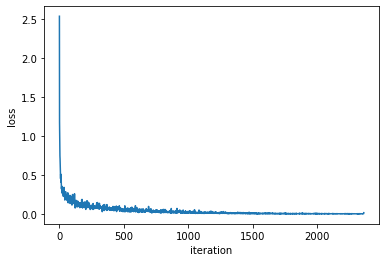

In [4]:
net=NN()
n_epochs=20
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
loss = torch.nn.CrossEntropyLoss()
losses=[]
for epoch in range(n_epochs):
    print("Epoch: ", epoch+1, '/', n_epochs, end='\r')
    net.train()
    for x, y in trainloader:
        out=net(x)
        l=loss(out, y)
        losses.append(l)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    scheduler.step()
plt.plot(losses)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

As expected, accuracy is $\sim 100\%$ on the training data. Moreover, even test set performance is decent, reaching $97.5\%$. 

In [5]:
net.eval()
correct=0
with torch.no_grad():
    for x, y in trainloader:
        out=net(x)
        correct+=(torch.argmax(out, axis=1)==y).sum().item()
print("Accuracy on training set: ", correct/len(trainset))

correct=0
with torch.no_grad():
    for x, y in testloader:
        out=net(x)
        correct+=(torch.argmax(out, axis=1)==y).sum().item()
print("Accuracy on test set: ", correct/len(testset))

Accuracy on training set:  0.9999833333333333
Accuracy on test set:  0.9757


### 2

Things get more complicated if labels are permuted in the training set. Actually, one would probably expect the network not to converge at all, since images with the same labels now share no similarity whatsoever. However, if the network is sufficiently overparameterized, it is able to overfit to basically any data.

In [6]:
permuted_index = torch.randperm(len(trainset.targets))
trainset.targets = trainset.targets[permuted_index]
trainloader_permuted = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)

To achieve $100\%$ accuracy in this setting, a slightly more complex architecture is needed: this new MLP has two hidden layers, with $1024$ and $512$ neurons, and uses `LeakyReLU` activations instead of plain `ReLU` (the difference being that negative inputs are not transformed into $0$ but into very small negative values, according to a linear relation).

In less than $100$ epochs this model reaches perfect accuracy on training data.

In [7]:
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512,10)
        )
    def forward(self, x):
        return (self.layers(x.view(-1,784)))

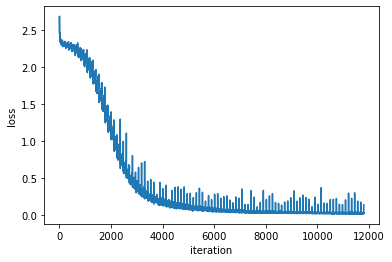

In [8]:
net=NN()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
loss = torch.nn.CrossEntropyLoss()
losses=[]
for epoch in range(100):
    print("Epoch: ", epoch+1, '/', 100, end='\r')
    net.train()
    for x, y in trainloader_permuted:
        out=net(x)
        l=loss(out, y)
        losses.append(l)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    scheduler.step()
plt.plot(losses)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

As expected, performance on training data (with permutations) is almost perfect ($99.99\%$ accuracy). However, since the learning was done on randomly permuted labels, test set (without permutations) performance is not better than random classification ($\sim 10\%$ accuracy).

In [9]:
net.eval()
correct=0
with torch.no_grad():
    for x, y in trainloader_permuted:
        out=net(x)
        correct+=(torch.argmax(out, axis=1)==y).sum().item()
print("Accuracy on training set (with permuted labels): ", correct/len(trainset))

correct=0
with torch.no_grad():
    for x, y in testloader:
        out=net(x)
        correct+=(torch.argmax(out, axis=1)==y).sum().item()
print("Accuracy on test set (with original labels): ", correct/len(testset))

Accuracy on training set (with permuted labels):  0.9998666666666667
Accuracy on test set (with original labels):  0.0979
